In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-09-07 14:34:38.100679: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 14:34:38.151849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 14:34:38.947710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/ResNet101V2'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 requires images of size 224x224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))

In [7]:
# Split the dataset
create_splits()

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1537 images belonging to 5 classes.
Found 739 images belonging to 5 classes.
Found 770 images belonging to 5 classes.


In [11]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-09-07 14:34:41.325054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46207 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-07 14:34:51.474686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-09-07 14:34:51.769882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-07 14:34:52.118594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb993cacaf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-07 14:34:52.118622: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-07 14:34:52.124190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 14:34:52.281885: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

48/48 [==============================] - ETA: 0s - loss: 2.0751 - accuracy: 0.2033

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 30s 482ms/step - loss: 2.0751 - accuracy: 0.2033 - val_loss: 1.8829 - val_accuracy: 0.1929
Epoch 2/50
48/48 [==============================] - 22s 466ms/step - loss: 1.9479 - accuracy: 0.2207 - val_loss: 1.7865 - val_accuracy: 0.2215
Epoch 3/50
48/48 [==============================] - 22s 451ms/step - loss: 1.8981 - accuracy: 0.2359 - val_loss: 1.7244 - val_accuracy: 0.2378
Epoch 4/50
48/48 [==============================] - 22s 453ms/step - loss: 1.8571 - accuracy: 0.2465 - val_loss: 1.6812 - val_accuracy: 0.2541
Epoch 5/50
48/48 [==============================] - 22s 451ms/step - loss: 1.8085 - accuracy: 0.2319 - val_loss: 1.6605 - val_accuracy: 0.2663
Epoch 6/50
48/48 [==============================] - 22s 460ms/step - loss: 1.7493 - accuracy: 0.2352 - val_loss: 1.6478 - val_accuracy: 0.2921
Epoch 7/50
48/48 [==============================] - 22s 458ms/step - loss: 1.7244 - accuracy: 0.2691 - val_loss: 1.6391 - val_accuracy: 0.2867
Epoch 8/50

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 78ms/step - loss: 1.4791 - accuracy: 0.3636
Test accuracy: 0.36


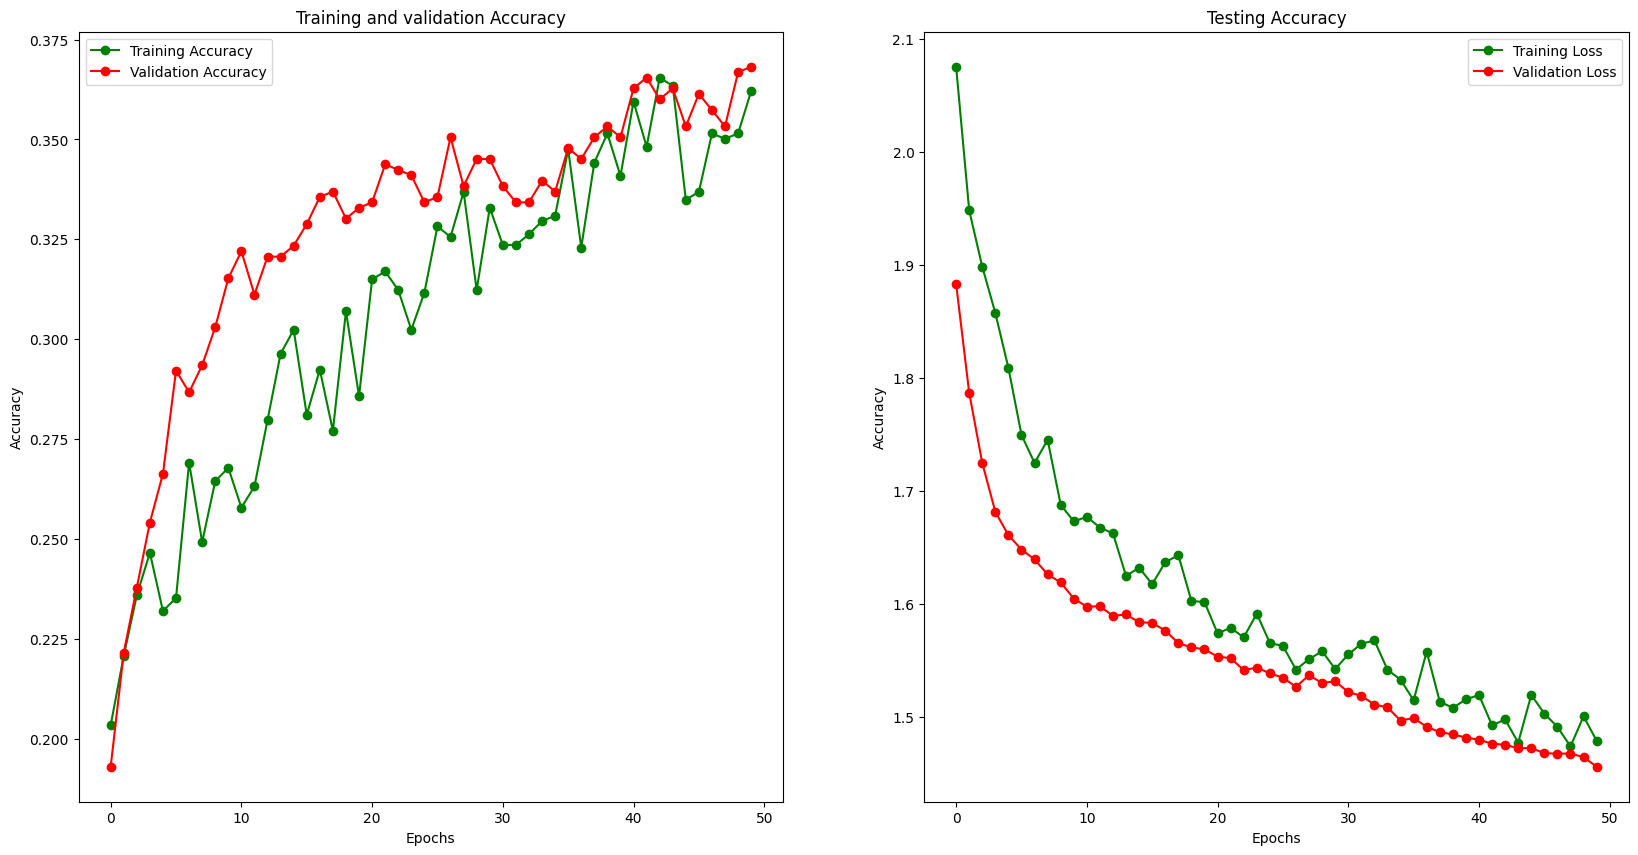

In [14]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 3s 71ms/step


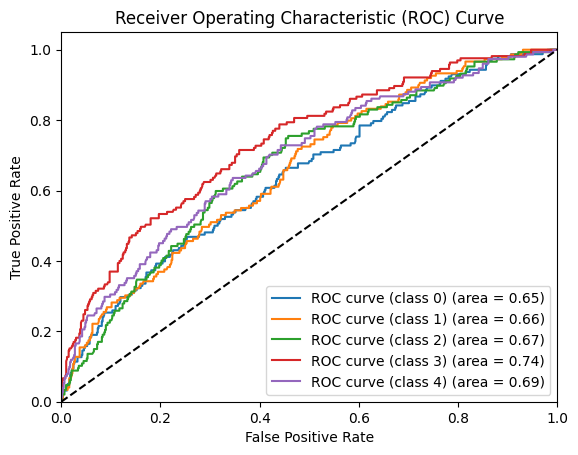

In [15]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculations for Architecture No 1 

In [16]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 84ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.17
Precision: 0.17
Recall: 0.17
F1 Score: 0.17
F2 Score: 0.17


In [17]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 69ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.49


# Architecture No 2

In [18]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.9998 - accuracy: 0.2040

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 29s 466ms/step - loss: 1.9998 - accuracy: 0.2040 - val_loss: 1.6511 - val_accuracy: 0.2133
Epoch 2/50
48/48 [==============================] - 22s 452ms/step - loss: 1.8884 - accuracy: 0.2252 - val_loss: 1.6309 - val_accuracy: 0.2269
Epoch 3/50
48/48 [==============================] - 21s 446ms/step - loss: 1.8800 - accuracy: 0.2259 - val_loss: 1.6170 - val_accuracy: 0.2459
Epoch 4/50
48/48 [==============================] - 21s 451ms/step - loss: 1.8169 - accuracy: 0.2173 - val_loss: 1.6128 - val_accuracy: 0.2418
Epoch 5/50
48/48 [==============================] - 22s 452ms/step - loss: 1.8016 - accuracy: 0.2346 - val_loss: 1.6127 - val_accuracy: 0.2473
Epoch 6/50
48/48 [==============================] - 20s 418ms/step - loss: 1.7608 - accuracy: 0.2558 - val_loss: 1.6165 - val_accuracy: 0.2582
Epoch 7/50
48/48 [==============================] - 21s 428ms/step - loss: 1.7520 - accuracy: 0.2419 - val_loss: 1.6201 - val_accuracy: 0.2609
Epoch 8/50

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 57ms/step - loss: 1.6228 - accuracy: 0.2468
Test accuracy: 0.25


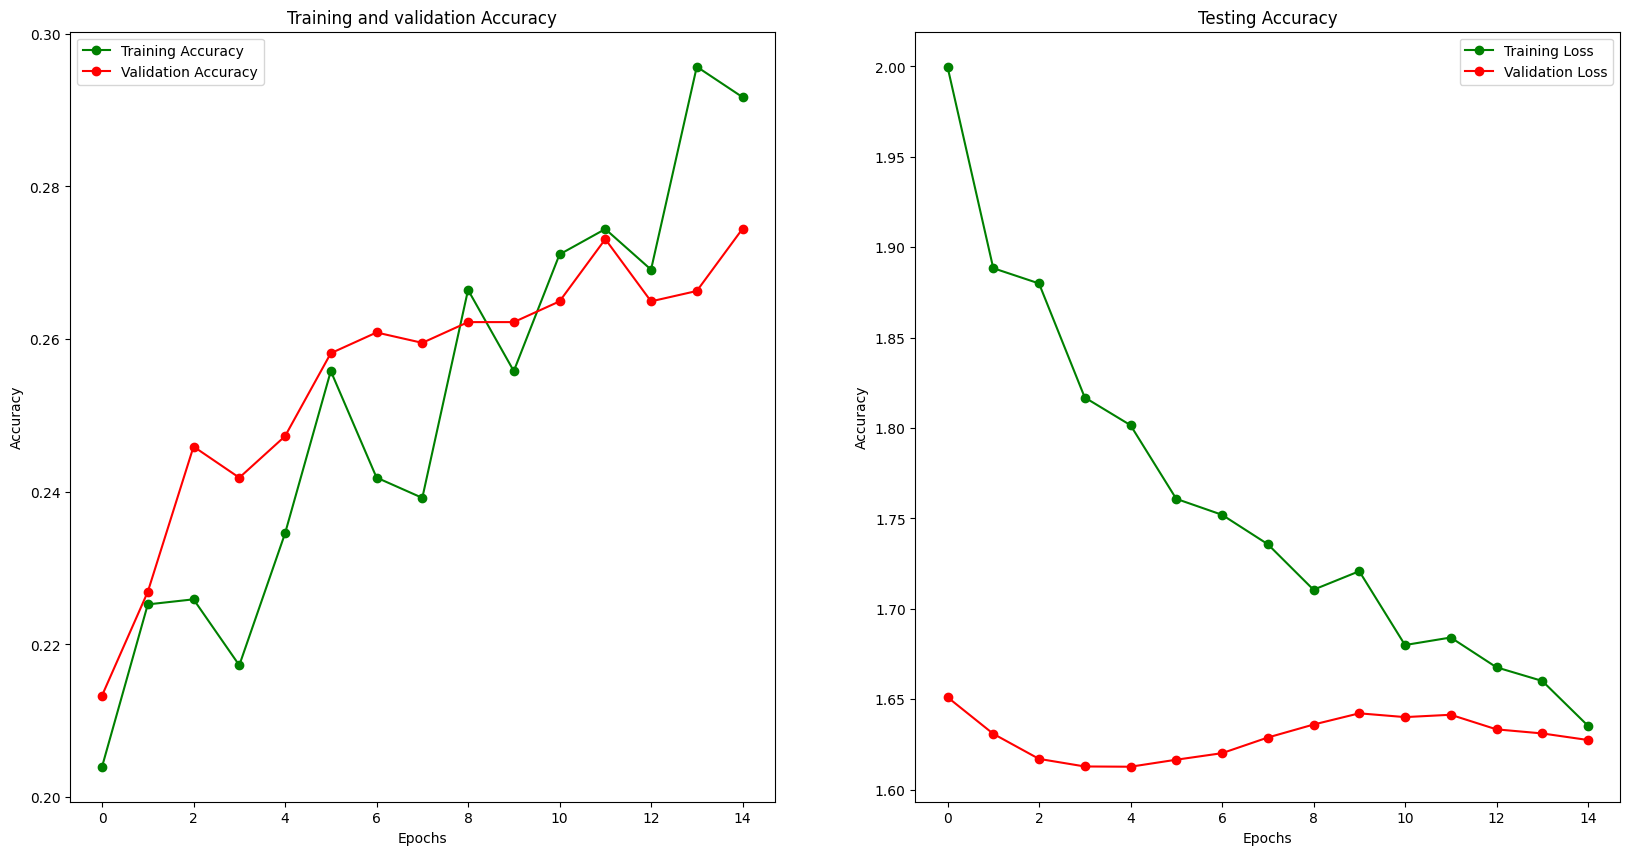

In [21]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 4s 79ms/step


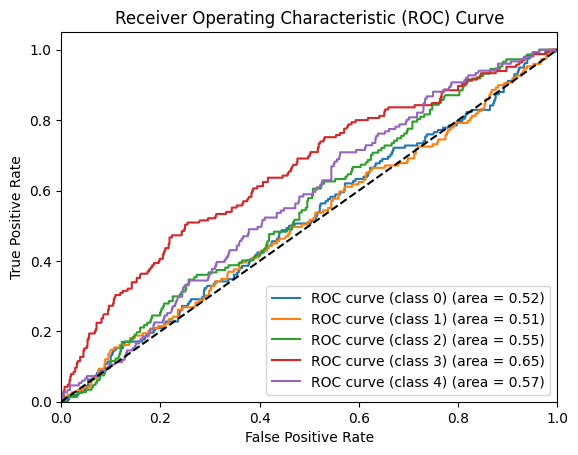

In [22]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 2 

In [23]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 74ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.19
Precision: 0.19
Recall: 0.19
F1 Score: 0.19
F2 Score: 0.19


In [24]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 78ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.51


# Architecture No 4

In [25]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.8383 - accuracy: 0.2306

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 29s 481ms/step - loss: 1.8383 - accuracy: 0.2306 - val_loss: 1.5866 - val_accuracy: 0.2446
Epoch 2/50
48/48 [==============================] - 22s 451ms/step - loss: 1.7211 - accuracy: 0.2664 - val_loss: 1.5533 - val_accuracy: 0.2677
Epoch 3/50
48/48 [==============================] - 22s 455ms/step - loss: 1.6549 - accuracy: 0.3056 - val_loss: 1.5448 - val_accuracy: 0.2853
Epoch 4/50
48/48 [==============================] - 22s 457ms/step - loss: 1.6088 - accuracy: 0.3050 - val_loss: 1.5307 - val_accuracy: 0.3288
Epoch 5/50
48/48 [==============================] - 22s 454ms/step - loss: 1.5990 - accuracy: 0.3282 - val_loss: 1.5006 - val_accuracy: 0.3410
Epoch 6/50
48/48 [==============================] - 21s 445ms/step - loss: 1.5594 - accuracy: 0.3355 - val_loss: 1.4916 - val_accuracy: 0.3383
Epoch 7/50
48/48 [==============================] - 22s 448ms/step - loss: 1.5622 - accuracy: 0.3316 - val_loss: 1.4707 - val_accuracy: 0.3546
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 87ms/step - loss: 1.1619 - accuracy: 0.5377
Test accuracy: 0.54


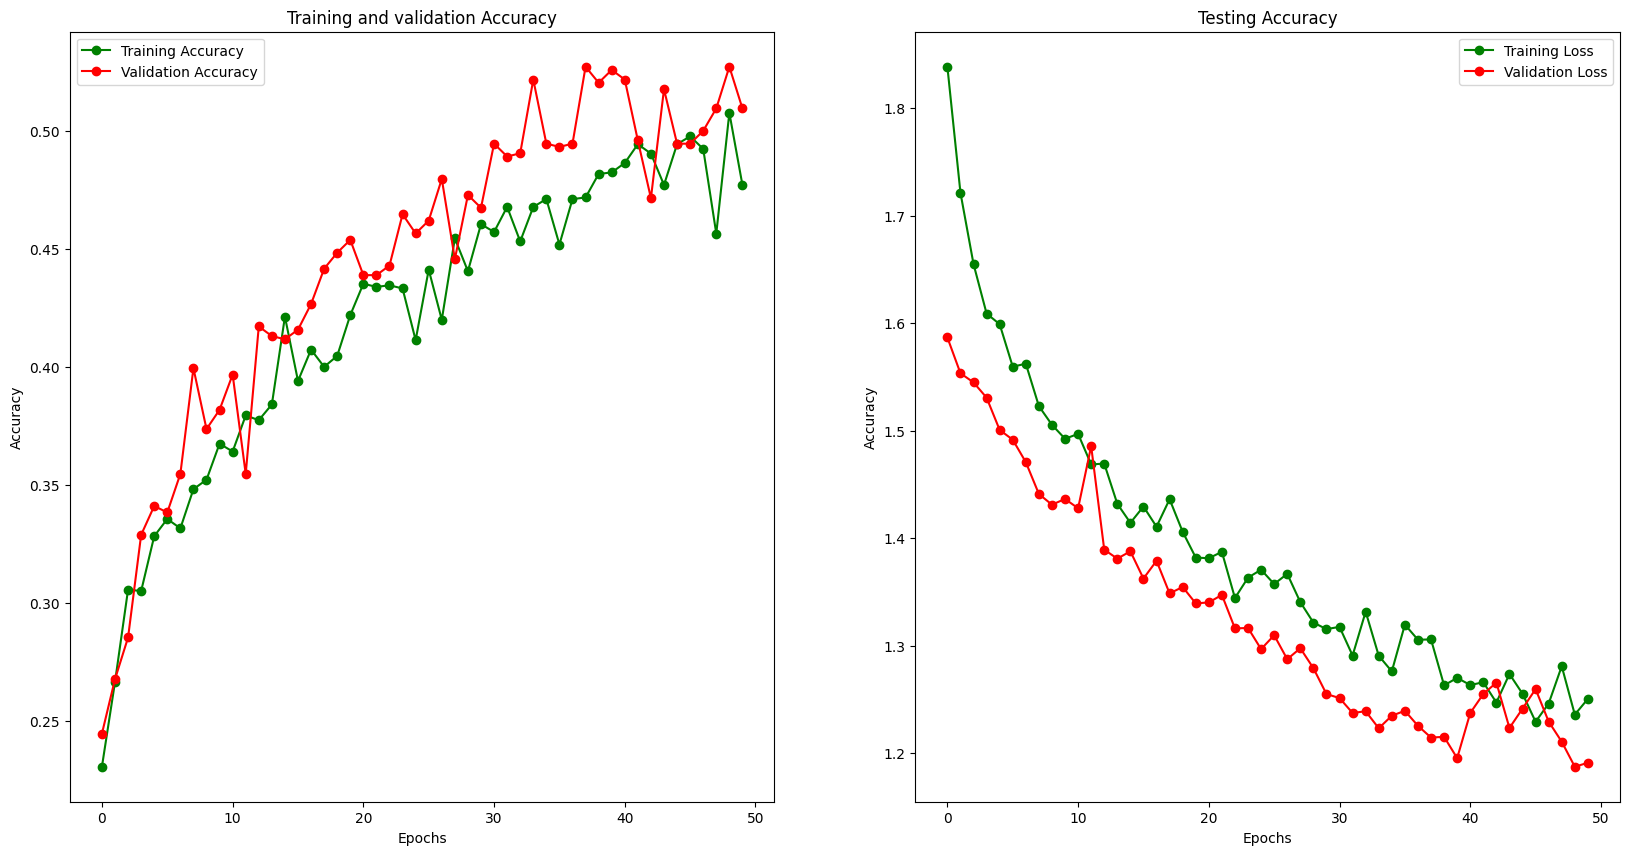

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 3s 69ms/step


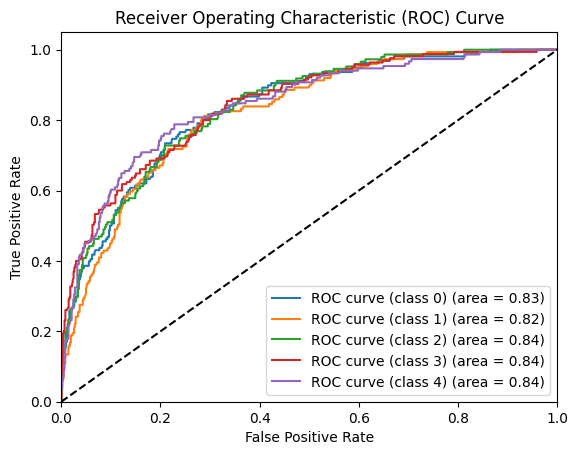

In [29]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Metric Report Calculation for Architecture No 4 

In [30]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 80ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.19
Precision: 0.19
Recall: 0.19
F1 Score: 0.19
F2 Score: 0.19


In [31]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 74ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.52


# Architecture No 5

In [32]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [33]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.9462 - accuracy: 0.2153

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 30s 476ms/step - loss: 1.9462 - accuracy: 0.2153 - val_loss: 1.5904 - val_accuracy: 0.2486
Epoch 2/50
48/48 [==============================] - 22s 448ms/step - loss: 1.7317 - accuracy: 0.2618 - val_loss: 1.5429 - val_accuracy: 0.2758
Epoch 3/50
48/48 [==============================] - 22s 455ms/step - loss: 1.6608 - accuracy: 0.2950 - val_loss: 1.5369 - val_accuracy: 0.2935
Epoch 4/50
48/48 [==============================] - 22s 453ms/step - loss: 1.6231 - accuracy: 0.3003 - val_loss: 1.5092 - val_accuracy: 0.3288
Epoch 5/50
48/48 [==============================] - 22s 452ms/step - loss: 1.5659 - accuracy: 0.3282 - val_loss: 1.4941 - val_accuracy: 0.3438
Epoch 6/50
48/48 [==============================] - 21s 429ms/step - loss: 1.5300 - accuracy: 0.3488 - val_loss: 1.4944 - val_accuracy: 0.3465
Epoch 7/50
48/48 [==============================] - 22s 451ms/step - loss: 1.5311 - accuracy: 0.3442 - val_loss: 1.4477 - val_accuracy: 0.3954
Epoch 8/50

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 70ms/step - loss: 1.0809 - accuracy: 0.5844
Test accuracy: 0.58


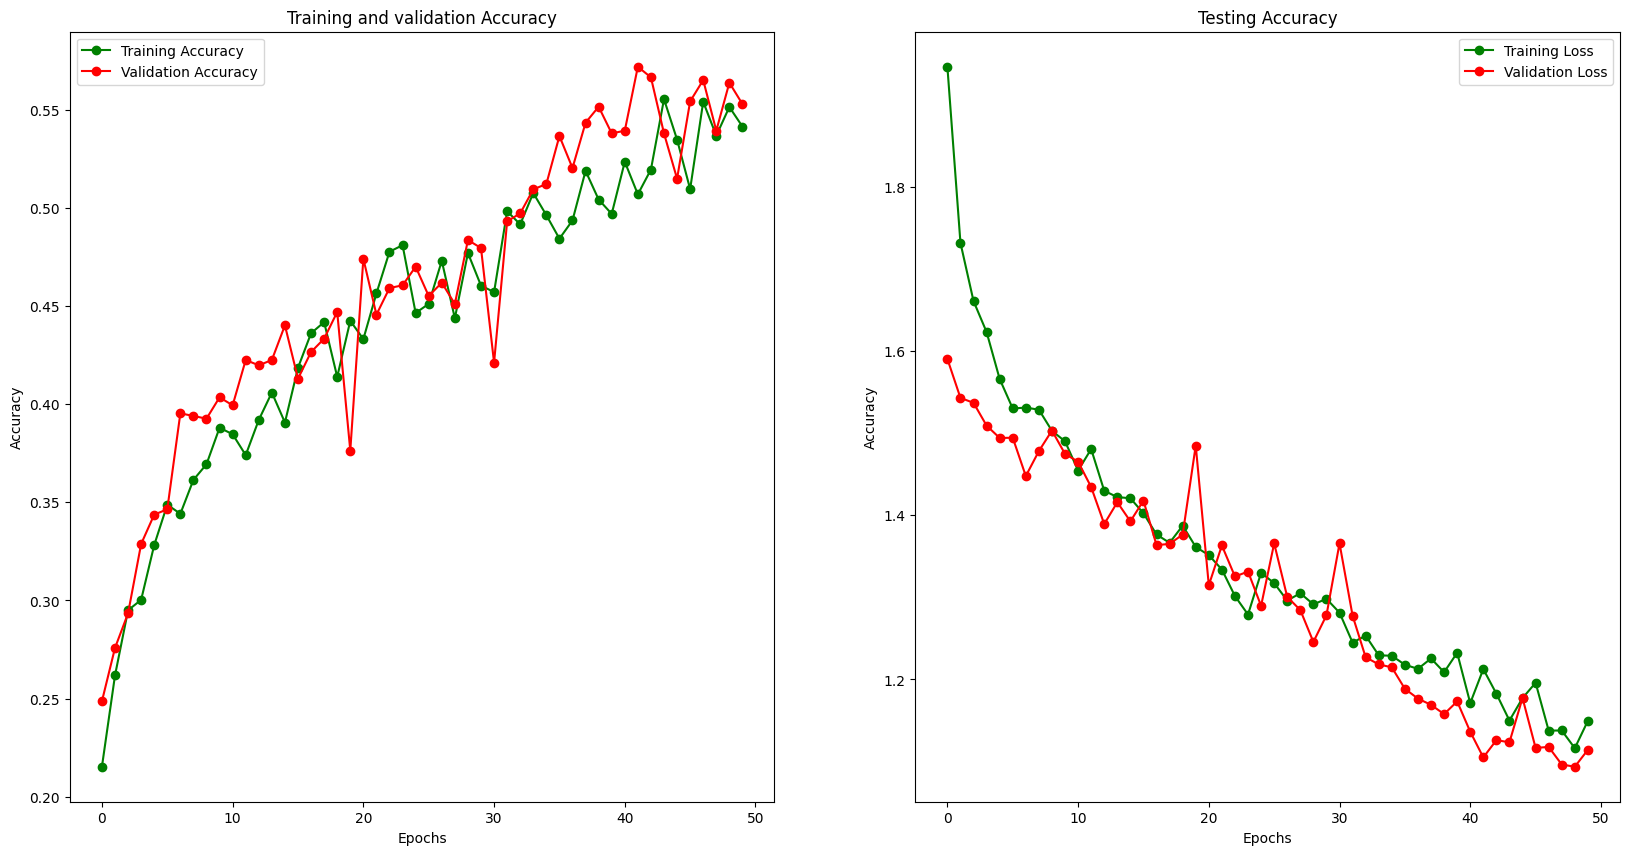

In [35]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 3s 77ms/step


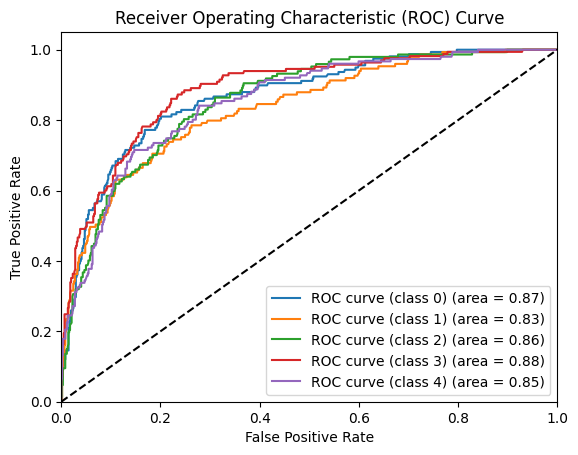

In [36]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 5 

In [37]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 75ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.19
Precision: 0.19
Recall: 0.19
F1 Score: 0.19
F2 Score: 0.19


In [38]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 75ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.51


# Architecture No 6

In [39]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [40]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.8455 - accuracy: 0.2266

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 31s 502ms/step - loss: 1.8455 - accuracy: 0.2266 - val_loss: 1.6013 - val_accuracy: 0.2541
Epoch 2/50
48/48 [==============================] - 22s 461ms/step - loss: 1.7526 - accuracy: 0.2439 - val_loss: 1.5733 - val_accuracy: 0.2663
Epoch 3/50
48/48 [==============================] - 22s 451ms/step - loss: 1.6859 - accuracy: 0.2744 - val_loss: 1.5599 - val_accuracy: 0.2758
Epoch 4/50
48/48 [==============================] - 22s 451ms/step - loss: 1.6404 - accuracy: 0.2844 - val_loss: 1.5384 - val_accuracy: 0.3220
Epoch 5/50
48/48 [==============================] - 22s 454ms/step - loss: 1.6311 - accuracy: 0.2864 - val_loss: 1.5209 - val_accuracy: 0.3288
Epoch 6/50
48/48 [==============================] - 22s 451ms/step - loss: 1.5731 - accuracy: 0.3050 - val_loss: 1.5009 - val_accuracy: 0.3397
Epoch 7/50
48/48 [==============================] - 21s 445ms/step - loss: 1.5781 - accuracy: 0.3017 - val_loss: 1.4985 - val_accuracy: 0.3519
Epoch 8/50

In [41]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 88ms/step - loss: 1.2829 - accuracy: 0.4688
Test accuracy: 0.47


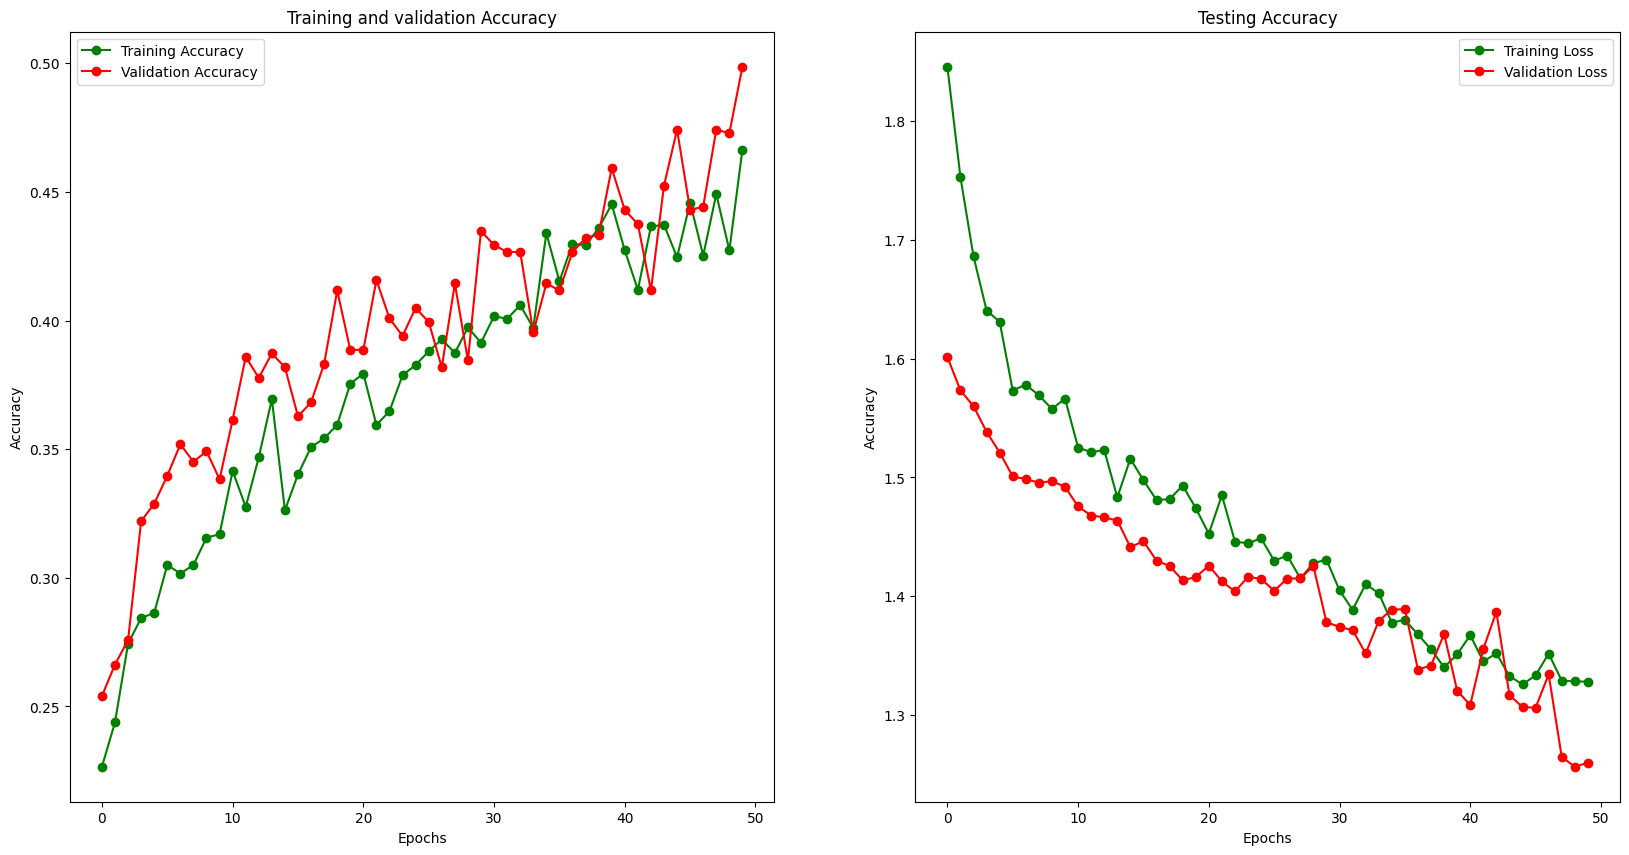

In [42]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 4s 81ms/step


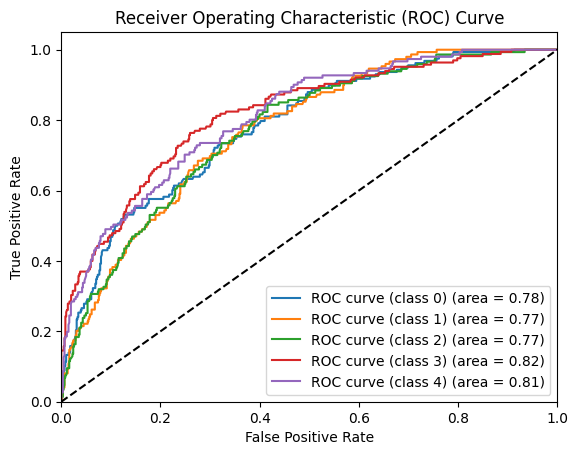

In [43]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architectutre No 6 

In [44]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 75ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.21
Precision: 0.21
Recall: 0.21
F1 Score: 0.20
F2 Score: 0.21


In [45]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 74ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.50


# Architecture No 7

In [46]:
# Load the ResNet101V2 model pretrained on ImageNet
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [47]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 1.8021 - accuracy: 0.2425

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 30s 478ms/step - loss: 1.8021 - accuracy: 0.2425 - val_loss: 1.5883 - val_accuracy: 0.2867
Epoch 2/50
48/48 [==============================] - 22s 454ms/step - loss: 1.7054 - accuracy: 0.2757 - val_loss: 1.5562 - val_accuracy: 0.3043
Epoch 3/50
48/48 [==============================] - 22s 450ms/step - loss: 1.6684 - accuracy: 0.2884 - val_loss: 1.5242 - val_accuracy: 0.3261
Epoch 4/50
48/48 [==============================] - 22s 459ms/step - loss: 1.6376 - accuracy: 0.2977 - val_loss: 1.5148 - val_accuracy: 0.3451
Epoch 5/50
48/48 [==============================] - 22s 447ms/step - loss: 1.6264 - accuracy: 0.3050 - val_loss: 1.4879 - val_accuracy: 0.3533
Epoch 6/50
48/48 [==============================] - 22s 459ms/step - loss: 1.5658 - accuracy: 0.3333 - val_loss: 1.4646 - val_accuracy: 0.3546
Epoch 7/50
48/48 [==============================] - 21s 433ms/step - loss: 1.5346 - accuracy: 0.3375 - val_loss: 1.4672 - val_accuracy: 0.3573
Epoch 8/50

In [48]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

25/25 [==============================] - 2s 83ms/step - loss: 1.1749 - accuracy: 0.5169
Test accuracy: 0.52


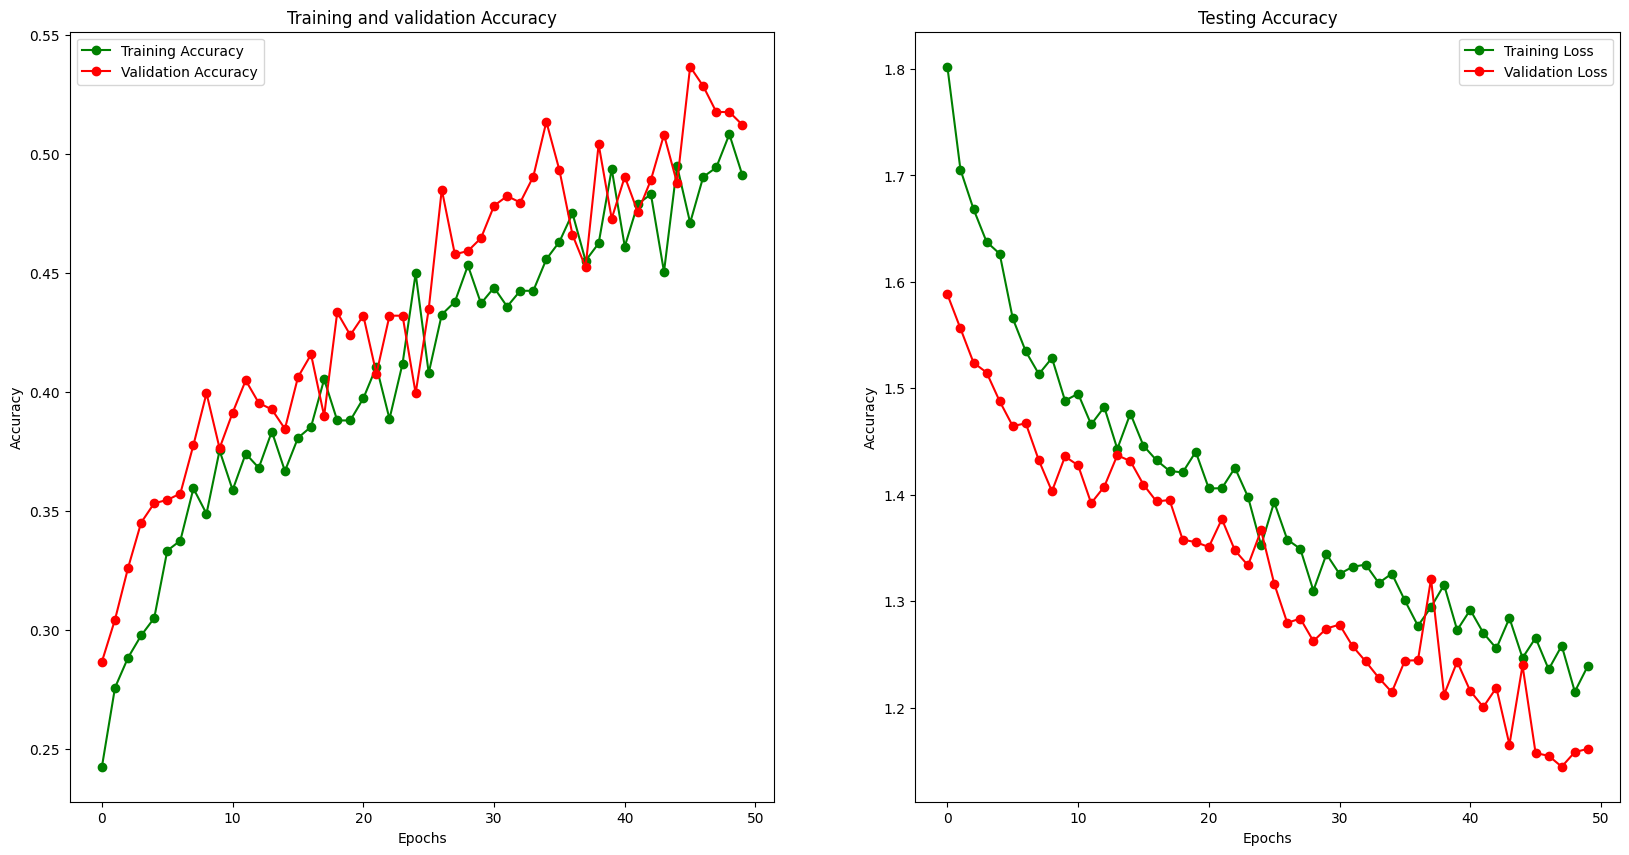

In [49]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

25/25 [==============================] - 3s 72ms/step


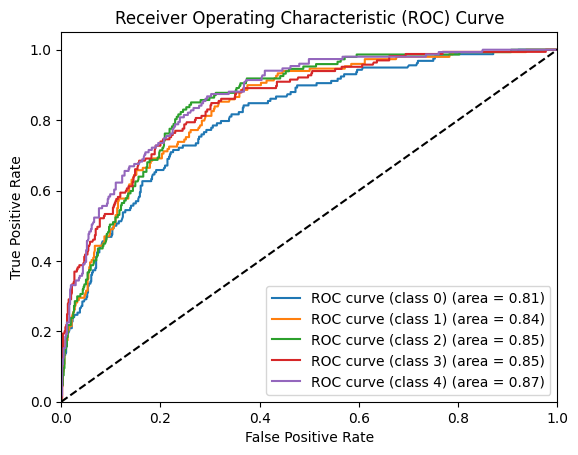

In [50]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Metric Report Calculation for Architecture No 7 

In [51]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

24/24 [==============================] - 2s 76ms/step
Length of y_true: 739
Length of y_pred_classes: 739
Accuracy: 0.22
Precision: 0.22
Recall: 0.22
F1 Score: 0.21
F2 Score: 0.21


In [52]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

24/24 [==============================] - 2s 76ms/step
Length of y_true: 739
Length of y_pred: 739
Average AUC: 0.50
